# Detecting Synchronicity with Unitary Event Analysis (UEA)

## 1 Preparation

Import the modules required for this notebook

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import quantities as pq
from neo.io import NixIO
import elephant.unitary_event_analysis as ue
from elephant.spike_train_generation import StationaryPoissonProcess, NonStationaryPoissonProcess
from elephant.datasets import download_datasets
from viziphant.unitary_event_analysis import plot_ue
from viziphant.rasterplot import rasterplot
np.random.seed(15)
%matplotlib inline

Download the data required for this notebook

In [2]:
repo_path = "tutorials/tutorial_unitary_event_analysis/data/dataset-1.nix"
filepath = download_datasets(repo_path)

Define the utility functions required for this notebook

In [3]:
from neo.core import AnalogSignal
import pandas as pd
from elephant.spike_train_surrogates import trial_shifting


class utils:
    @staticmethod
    def spike_trains_with_unitary_events(base_rate, sync_rate, n_neurons, n_trials):
        np.random.seed(100)
        base = StationaryPoissonProcess(rate=base_rate, t_stop=2 * pq.s)

        rate_signal = np.zeros(2000) * pq.Hz
        rate_signal[1000:1200] = sync_rate
        rate_signal = AnalogSignal(rate_signal, sampling_rate=1000 * pq.Hz)

        sync = NonStationaryPoissonProcess(rate_signal)
        sync_spikes = sync.generate_n_spiketrains(n_trials)

        trials = []
        for t in range(n_trials):
            trial = []
            for n in range(n_neurons):
                trial.append(base.generate_spiketrain().merge(sync_spikes[t]))
            trials.append(trial)
        return trials, sync_spikes

    @staticmethod
    def spike_trains_with_rate_step(base_rate, rate_step, n_neurons, n_trials):
        np.random.seed(100)
        rate_signal = np.ones(2000) * base_rate
        rate_signal[1000:1200] += rate_step
        rate_signal = AnalogSignal(rate_signal, sampling_rate=1000 * pq.Hz)
        neuron = NonStationaryPoissonProcess(rate_signal)
        trials = [neuron.generate_n_spiketrains(n_neurons) for i in range(n_trials)]
        return trials

## 2 Simulating Neurons with Coincident Firing

In this notebook we want to explore the unitary event analysis (UEA)
method for detecting synchronous events in parallel spike trains. To
test this method, we need a to simulate spike trains that contain these
synchronous events. In this section, you are going to explore a custom
simulation function that generates spike trains for multiple neurons.
These neurons have a baseline firing rate, which determines their random
spiking, as well as a synchronous rate that determines the spikes that
appear synchronously in all neurons. In this section we are going to
generate spike trains with this method and visualize them.

| Code | Description |
|------------------------------------|------------------------------------|
| `trials, sync_spikes = utils.spike_trains_with_unitary_events()` | Simulate spike trains that contain synchronous events and return a list of `trials` where each element is a list of spike trains (one per neuron) as well as a list `sync_spikes` that contains the synchronous spikes for every trial |
| `[trial[0].times for trial in trials]` | Get a list of spike `.times` for neuron `[0]` for each `trial` in the list of `trials` |
| `[st.times for st in sync_spikes]` | Get a list of spike `.times` for each spike train `st` in the list of `sync_spikes` |
| `plt.eventplot(x, linelength=0.5, color="red")` | Create an eventplot for the values in `x` with the given `linelength` and `color` |
| `plt.subplot(2, 1, 1)` | Create the first plot in a 2-by-1 subplot grid |
| `plt.subplot(2, 1, 2)` | Create the second plot in a 2-by-1 subplot grid |

------------------------------------------------------------------------

<span class="theorem-title">**Example 1**</span> Simulate `2` neurons
with a `base_rate` of `5*pq.Hz` and a `sync_rate` of `1*pq.Hz` for
`25 trials`. The returned `trials` are a list with one element per trial
and each element contains one spike train per neuron. `sync_spikes` is a
list of spike trains in each trial that appear synchronously in both
neurons.

In [4]:
trials, sync_spikes = utils.spike_trains_with_unitary_events(
    n_neurons=2, n_trials=25, base_rate=5 * pq.Hz, sync_rate=1 * pq.Hz
)

<span class="theorem-title">**Example 2**</span> Use `plt.eventplot` to
create a rasterplot for the spike trains in `trials` from the first
neuron.

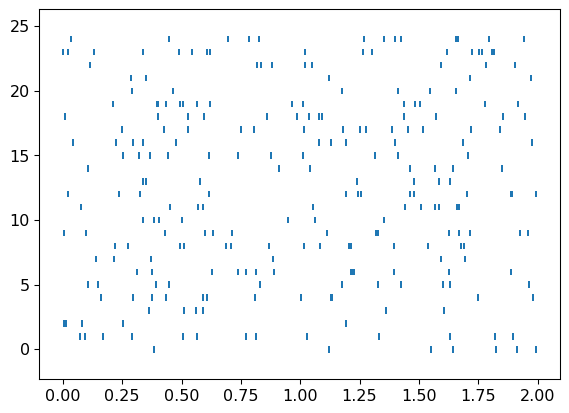

In [5]:
plt.eventplot([trial[0].times for trial in trials], linelength=0.5);

<span class="theorem-title">**Exercise 1**</span> Use `plt.eventplot` to
create a rasterplot for the spike trains in `trials` from the second
neuron.

​

<span class="theorem-title">**Exercise 2**</span> Use `plt.eventplot` to
create a rasterplot for the spike trains in `sync_spikes`.

​

<span class="theorem-title">**Example 3**</span> Plot the spike trains
from both neurons in a 2-by-1 subplot grid and plot the events in
`sync_spikes` in `"red"` with a larger `linelength` to both subplots.

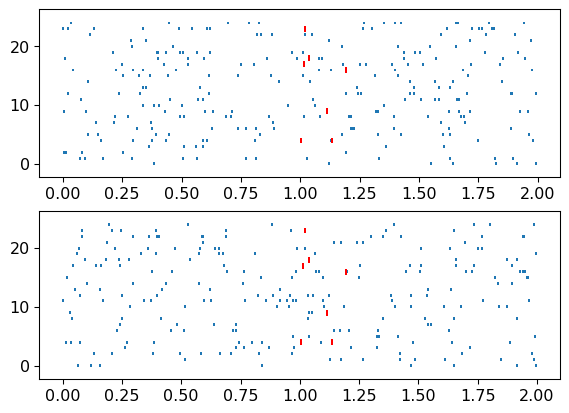

In [10]:
plt.subplot(2, 1, 1)
plt.eventplot([trial[0].times for trial in trials], linelength=0.5)
plt.eventplot([st.times for st in sync_spikes], color="red", linelength=1)

plt.subplot(2, 1, 2)
plt.eventplot([trial[1].times for trial in trials], linelength=0.5)
plt.eventplot([st.times for st in sync_spikes], color="red", linelength=1);

<span class="theorem-title">**Exercise 3**</span> Simulate `2` neurons
for with a `base_rate` of `10*pq.Hz` and a `sync_rate` of `2*pq.Hz` for
`25 trials`.

​

<span class="theorem-title">**Exercise 4**</span> Plot the spike trains
from both neurons in a 2-by-1 subplot grid and plot the events in
`sync_spikes` in `"red"` with a larger `linelength` to both subplots.

​

<span class="theorem-title">**Exercise 5**</span> Simulate `2` neurons
for `25` trials with `base_rate=5*pq.Hz` and a `sync_rate=2*pq.Hz`.
Then, plot the spike trains from both neurons in a 2-by-1 subplot grid
and plot the events in `sync_spikes` in `"red"` to both subplots.

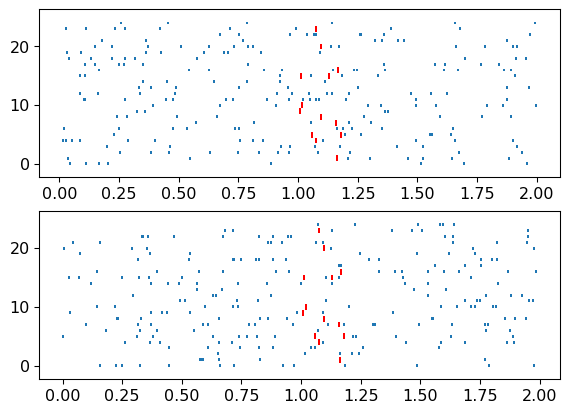

In [15]:
trials, sync_spikes = utils.spike_trains_with_unitary_events(
    base_rate=5 * pq.Hz, sync_rate=2 * pq.Hz, n_neurons=2, n_trials=25
)
plt.subplot(2, 1, 1)
plt.eventplot([trial[0].times for trial in trials], linelength=0.5)
plt.eventplot([st.times for st in sync_spikes], color="red", linelength=1)

plt.subplot(2, 1, 2)
plt.eventplot([trial[1].times for trial in trials], linelength=0.5)
plt.eventplot([st.times for st in sync_spikes], color="red", linelength=1);

​

## 3 Applying Unitary Event Analysis to Simulated Data

Now we can apply UEA to the simulated data. In order to apply UEA the
spike trains must be binned. The bin size is an important factor in the
analysis because events are considered synchronous if they fall into the
same bin. Another critical parameter is the window size in which UEA
looks for synchronous events. A larger window increases the statistical
power because it increases the number of data points for analysis but it
also reduces the temporal precision of the method. In this section we
are going to apply UEA to the simulated data and explore the effect of
these parameters.

| Code | Description |
|------------------------------------|------------------------------------|
| `UE = ue.jointJ_window_analysis(trials)` | Perform unitary event analysis on the list of `trials` |
| `UE = ue.jointJ_window_analysis(trials, bin_size=1*pq.ms)` | Perform unitary event analysis on the list of `trials` using a `bin_size` of 1 ms |
| `plot_ue(trials, UE, significance_level=0.05)` | Plot the `trials` and the unitary event analysis result `UE` and highlight spikes that exceed the given significance threshold |

------------------------------------------------------------------------

<span class="theorem-title">**Example 4**</span> Run the
`ue.jointJ_window_analysis()` to apply UEA to the simulated `trials` and
plot the `uea_result`.

FigureUE(axes_spike_events=<Axes: title={'center': 'Spike Events'}, ylabel='Trial'>, axes_spike_rates=<Axes: title={'center': 'Spike Rates'}, ylabel='Hz'>, axes_coincident_events=<Axes: title={'center': 'Coincident Events'}, ylabel='Trial'>, axes_coincidence_rates=<Axes: title={'center': 'Coincidence Rates'}, ylabel='Hz'>, axes_significance=<Axes: title={'center': 'Statistical Significance'}>, axes_unitary_events=<Axes: title={'center': 'Unitary Events'}, xlabel='Time (ms)', ylabel='Trial'>)

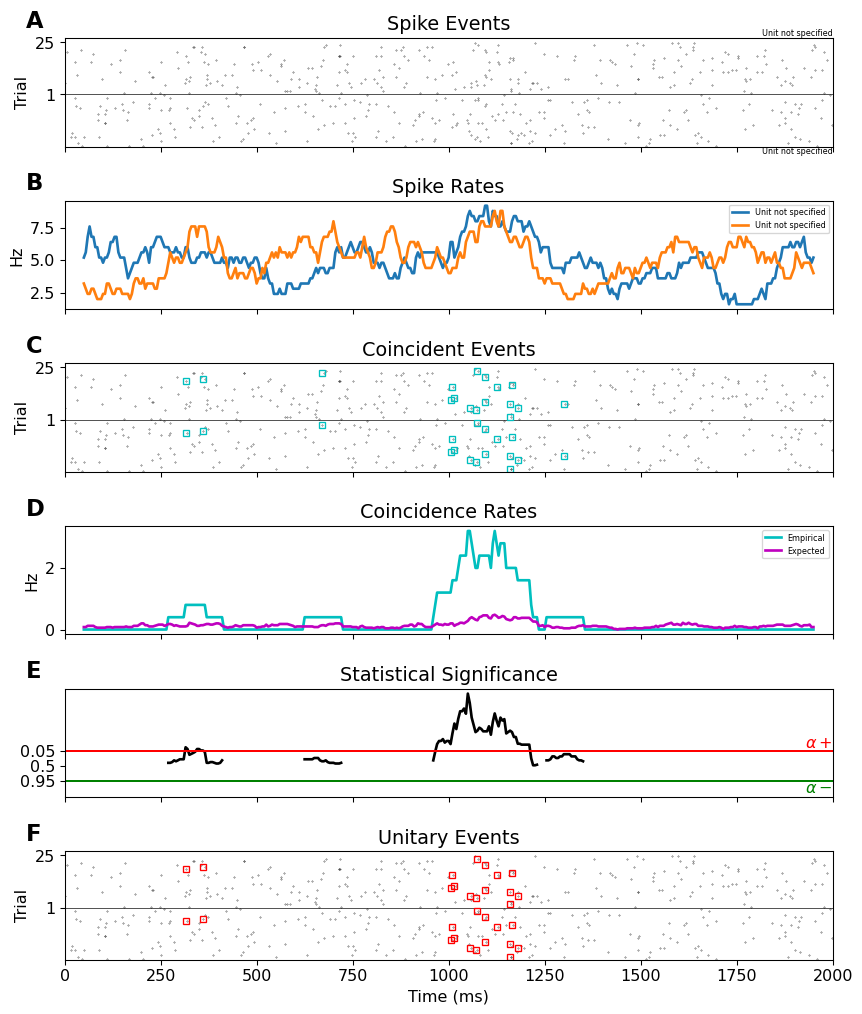

In [17]:
uea_result = ue.jointJ_window_analysis(trials)
plot_ue(trials, uea_result, significance_level=0.05)

<span class="theorem-title">**Exercise 6**</span> Plot the unitary event
analysis results again but increase the `significance_level` to `0.01`.

​

<span class="theorem-title">**Exercise 7**</span> Re-run the
`ue.jointJ_window_analysis()` on the simulated `trials` but set the
`win_size=200*pq.ms` and plot the results. What results did this have on
the statistical significance in panel E of the UEA plot?

​

<span class="theorem-title">**Exercise 8**</span> Reduce the `win_size`
to `25*pq.ms`, rerun the `ue.jointJ_window_analysis()` and plot the
result. How does the temporal spread of the significant events in panel
F of the UEA plot compare to the previous exercises?

​

<span class="theorem-title">**Exercise 9**</span> Further reduce the
`win_size` to `15*pq.ms` and rerun `ue.jointJ_window_analysis()`. Did
you find any significant events?

​

<span class="theorem-title">**Exercise 10**</span> Repeat the simulation
from <a href="#exr-sim1" class="quarto-xref">Exercise 7</a> but simulate
`100` trials and rerun the `ue.jointJ_window_analysis()`. Did you find
any significant events now?

​

<span class="theorem-title">**Exercise 11**</span> Simulate `2` neurons
for `25` trials with `base_rate=10*pq.Hz` and a `sync_rate=1*pq.Hz`.
Then, use `ue.jointJ_window_analysis()` with `bin_size=5*pq.ms` and plot
the result.

​

<span class="theorem-title">**Exercise 12**</span> Reduce the `bin_size`
to `1*pq.ms`, rerun the `ue.jointJ_window_analysis()` and plot the
result. How did the smaller bin size affect the number of coincident
events in panel C of the plot and the number of unitary events in panel
F?

​

<span class="theorem-title">**Exercise 13**</span> Repeat the simulation
from <a href="#exr-sim2" class="quarto-xref">Exercise 10</a> with
`n_neurons=3`, run the `ue.jointJ_window_analysis()`. How does the
larger number of neurons affect the number of coincident events in panel
C of the plot and the number of unitary events in panel F?

​

## 4 Limitations and Pitfalls of UEA

In this section, we will address two critical limitations of UEA. The
first is UEAs inability to deal with large numbers of neurons. This is
because UEA only considers events that appear synchronously in all
neurons. Thus, synchronous events are less likely the more neurons there
are. The second limitation is UEA’s tendency to produce false positives
if the firing rate of the neurons is highly non stationary (for example
if a neuron responds with bursts in spiking to a stimulus). In the
following, we will use simulations to explore these cases.

| Code | Description |
|------------------------------------|------------------------------------|
| `ph = ue.hash_from_pattern([0, 1, 1])` | Create a hash that represents a pattern where neuron 1 is inactive and neurons 2 and 3 are active |
| `UE = ue.jointJ_window_analysis(trials, pattern_hash=ph)` | Use UEA to search for the patterns indicated by the `pattern_hash` |
| `trials = utils.spike_trains_with_rate_step(base_rate, rate_step, n_neurons, n_trials)` | Simulate `n_neurons` with random spiking following a `base_rate` with `rate_step` at 1 second for `n_trials` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 14**</span> The code below
simulates a neuron that responds completely random and appends its spike
trains to the simulated `trials`. Run the `uea.jointJ_window_analysis()`
on the simulated `trials`. Did you find any unitary events?

In [34]:
neuron = StationaryPoissonProcess(rate=10 * pq.Hz, t_stop=2 * pq.s)
for t in range(len(trials)):
    trials[t].append(neuron.generate_spiketrain())

​

<span class="theorem-title">**Exercise 15**</span> The code below
generates a `pattern_hash` that encodes the pattern where neurons 1,2
and 3 are active but neuron 4 is not. Rerun the
`ue.jointJ_window_analysis()` with `pattern_hash=pattern_hash` and plot
the results.

In [37]:
pattern_hash = ue.hash_from_pattern([1, 1, 1, 0])
pattern_hash

14

​

<span class="theorem-title">**Exercise 16**</span> The code below
simulates three neurons with synchronous events and inserts two neurons
that are purely random at positions 2 and 4. Use unitary event analysis
with a `pattern_hash` that only searchers for synchronous activity in
neurons 1, 3 and 5 and ignores neurons 2 and 4.

In [40]:
trials, _ = utils.spike_trains_with_unitary_events(
    base_rate=10 * pq.Hz, sync_rate=1 * pq.Hz, n_neurons=3, n_trials=25
)
neuron = StationaryPoissonProcess(rate=10 * pq.Hz, t_stop=2 * pq.s)
for t in range(len(trials)):
    trials[t].insert(1, neuron.generate_spiketrain())
for t in range(len(trials)):
    trials[t].insert(3, neuron.generate_spiketrain())

​

<span class="theorem-title">**Exercise 17**</span> The code below
simulates `2` neurons that have no synchronous events at all but that
have a `base_rate` that increases by a `rate_step` exactly one second
into the trial. Run the `ue.jointJ_window_analysis()` on the simulated
`trials`. Can you see the increased firing rate in the plot?

In [43]:
trials = utils.spike_trains_with_rate_step(base_rate=3 * pq.Hz, rate_step=15 * pq.Hz, n_neurons=2, n_trials=20)

​

<span class="theorem-title">**Exercise 18**</span> Simulate new trials
with `rate_step=30*pq.Hz`. Then, rerun the `ue.jointJ_window_analysis()`
and plot the result.

​

<span class="theorem-title">**Exercise 19**</span> Rerun the
`ue.jointJ_window_analysis()` but increase the `win_size` to `250*pq.ms`
and plot the result

​

## 5 Applying Unitary Event Analysis to Real Data

Now that we explored UEA and its parameters using simulations, we can
apply it to real data. The data in this section was recorded in the
motor cortex of a monkey that was trained on a reaching task. In this
task the monkey receives the signal to execute the reaching movement at
one of several possible time points. It has been shown that, as the
monkey learns the times at which the cue can be presented is linked to
an increase in synchronous events between motor neurons around these
time intervals.

Run the cell below to load the data and return a list of trials

In [50]:
io = NixIO(f"{filepath}", "ro")
block = io.read_block()
trials = []
for ind in range(len(block.segments)):
    trials.append(block.segments[ind].spiketrains)

<span class="theorem-title">**Exercise 20**</span> Run the
`ue.jointJ_window_analysis` on the loaded `trials`. First, use the
default parameters. Then, vary the `bin_size` and `win_size` and observe
how this affects the results

​